# Stream Function Tendency Budget

### Written by: Will Chapman (wchapman@ucar.edu) or https://github.com/WillyChap
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

                                                                                            

                Copyright (C)  2023                                                         
                Will Chapman                                                             
                All Rights Reserved                                                          
          
**Descripition**:
This is a program calculates the dynamical decomposition terms of
low-frequency tendency based on equation (2) in the reference.


**Input data**: Daily U/V components of the wind (time,lat,lon) in a netcdf file named: ['U','V'], must be global, regular grid or gaussian grid.

**Output data**: NETCDF of dimension = Input with terms 1-7, linear terms, nonlinear terms,low frequency stream function, and low frequency stream function tendency (centered finite difference)


**REFERENCE**:
- Fundamental mechanisms of the growth and decay of the PNA teleconnection pattern (Feldstein, 2002). Equation 2

**Checking the function against**:

- Dynamics of the Northern Annular Mode at Weekly Time Scales (https://doi.org/10.1175/JAS-D-15-0069.1) (Gwendal & DROUARD 2015) [thanks for including dates] (Figure 11a/b/c) 

**Shout outs**

- Andrew Dawson's 'windspharm' package
- Peiqiang Xu for his NCL knowledge
- S. Feldstein for his Fortran code & comments in that code
- Gwendal & Drouard for writing the NAM dates down in a table

Find a yaml file for the python build environment @ https://github.com/WillyChap

;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

<em>If you use this notebook would be awesome if you cited the paper (but no worries if not, dog)</em>: 
- Chapman W.  & Berner J. (2023) Comparing Data Assimilation and Nudging Increments Tendency Adjustments in Addressing Model Bias in CAM6 (in Prep)


### History

- V1. April 18 2023 - initial build and testing



### Some Details

- Gradients, divergence, rotational componets,inverse laplacian, etc. are all done leveraging spherical harmonics
- Band pass is from 10d-90d
- Low pass is 10d+ 
- High pass is 1d-10d
- Filtering is done with FFT
- Climatology is built from a 90 day rolling average on either side of the date (using all years)
- U ~= Climo_U + band_pass_U + high_pass_U

## Critical things to pay attention to:

In [1]:
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')
print('attention this is currently only configured for daily data that has a leap year!!!!!!!!!!')

print('adjust the data to configure in this way, or change the regression of the season and the FFT filtering terms!!!!!!!!!!')

print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')
print('Attention Check the Orientation of your Dataset lat must go from 90 -> -90 (north-to-south)!!!!!!!!!!')

print('This notebook should automatically invert your latitude dimension... but check to be sure !!!!!!!!!!')

attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
attention this is currently only configured for daily data that has a leap year!!!!!!!!!!
adjust the data to configure in this way, or change the regression of the season and the FFT filtering terms!!!!!!!!!!
Attention Check the Orientation of your Dataset lat must go from 90 -> 

## Package Imports

In [2]:
import numpy as np
import numpy.ma as ma

import pandas as pd
import glob
import scipy
import copy

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy
from datetime import datetime
import os
import importlib

from eofs.xarray import Eof

#filtering tool: 
from scipy.signal import butter
from scipy import signal
import glob

import scipy.io as sio
import scipy.fftpack as fftpack

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import xarray as xr

import scipy as sp
import scipy.ndimage

In [3]:
# pip install windspharm

## Get all the Spherical Harmonics Tools

In [4]:
from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
from windspharm.examples import example_data_path
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.tools import prep_data, recover_data
import spharm.spharm

# Experiments: 
    -Free Running: 
        -/glade/campaign/cisl/aiml/wchapman/CAM_runs/f.e21.DAcompset.f09_d025_free_MJO_1982
        - path_tofiles=/glade/campaign/cisl/aiml/wchapman/CAM_runs/' + modvers + '/atm/hist/*h1*.nc
    -Nudge No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982
    -Nudge Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3
        - path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
    -DA No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982
    -DA Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/
    -obs
        -/glade/scratch/wchapman/TEMPERAI/

## References

- https://journals.ametsoc.org/view/journals/clim/11/4/1520-0442_1998_011_0523_trotdi_2.0.co_2.xml

- https://link.springer.com/article/10.1007/s00382-010-0873-4

- https://journals.ametsoc.org/view/journals/clim/28/21/jcli-d-14-00497.1.xml 


-  https://journals.ametsoc.org/view/journals/atsc/41/3/1520-0469_1984_041_0313_tefott_2_0_co_2.xml

- Formula C2 here: https://journals.ametsoc.org/view/journals/clim/31/11/jcli-d-17-0716.1.xml


#### barotropic energy conversion: 

- https://link.springer.com/article/10.1007/s00382-020-05279-2

- https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1256/0035900021643683

### This notebook is to test the formulation in this paper: 

- The Continuum and Dynamics of Northern Hemisphere Teleconnection Patterns (https://journals.ametsoc.org/view/journals/atsc/62/9/jas3536.1.xml)

### Big Ups to: Peiqiang XU for the conversation and NCL code. 
- "Intraseasonal variations of the British-Baikal Corridor pattern" (https://journals.ametsoc.org/view/journals/clim/33/6/jcli-d-19-0458.1.xml)

### TAN et al Paper: 
- The Role of Synoptic Waves in the Formation and Maintenance of the Western Hemisphere Circulation Pattern (https://journals.ametsoc.org/view/journals/clim/30/24/jcli-d-17-0158.1.xml)

### Gwendal Paper: 

- Dynamics of the Northern Annular Mode at Weekly Time Scales (https://doi.org/10.1175/JAS-D-15-0069.1)

## Used Functions

In [5]:
def is_ndjfm(month):
    return (month == 11) | (month == 12) | (month == 1) | (month == 2) | (month == 3)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
def is_jfm(month):
    return (month == 1) | (month == 2) | (month == 3)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
def is_jf(month):
    return (month == 1) | (month == 2)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))

def is_djf(month):
    return (month == 12) | (month == 1) | (month == 2)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))

def is_f(month):
    return (month == 2)
# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
def is_j(month):
    return (month == 1)

# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
def is_m(month):
    return (month == 3)

# seasonal_data = temp_data.sel(time=is_amj(temp_data['time.month']))
def is_d(month):
    return (month == 12)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

def regress_out_seasonal(ts):
    # Assume this is daily data... will not work if it isn't
    # Get the length of the input time series
    nt = len(ts)
    # Generate an array of time indices from 1 to nt
    time = np.arange(1, nt+1) # each value is one day
    # Create a matrix A2 with columns for the intercept and various seasonal cycles
    A2 = np.array([np.ones(nt), time, np.sin(2*np.pi*time/365.25), np.cos(2*np.pi*time/365.25),
                   np.sin(4*np.pi*time/365.25), np.cos(4*np.pi*time/365.25),
                   np.sin(6*np.pi*time/365.25), np.cos(6*np.pi*time/365.25),
                   np.sin(8*np.pi*time/365.25), np.cos(8*np.pi*time/365.25)]).T 
    # Compute the Moore-Penrose pseudoinverse of A2 to obtain regression coefficients
    x_dot_inv = np.dot(scipy.linalg.inv(np.dot(A2.T, A2)), np.dot(A2.T, ts))
    # Compute the linear fit of the input time series using the regression coefficients and A2
    fit = np.dot(A2, x_dot_inv)
    # Return the input time series with the seasonal variation removed by subtracting the fit
    return ts - fit


def fix_EOF(C_for,Pats):
    Pats = [Pats]
    C_for_rep = xr.zeros_like(C_for)

    # EOF_fix(Pats)
    for Pt in Pats:
        # print(Pt)
        if Pt == 'PNA':
            latdo = [30,75]
            londo = [180,220]

        if Pt == 'NPO':
            latdo = [60,89]
            londo = [0,360]

        if Pt == 'NAM':
            latdo = [60,89]
            londo = [0,360]

        if Pt == 'SAM':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'PSA1':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'PSA2':
            latdo = [-89,-60]
            londo = [0,360]

        if Pt == 'NAO':
            latdo = [60,89]
            londo = [0,360]
        Replace_EOF = np.zeros_like(C_for[Pt])
        Replace_PC  = np.zeros_like(C_for[Pt+'_PC'])
        for ii in range(len(C_for['member'])):
            if np.sum(C_for[Pt].sel(member=ii).sel(lat=slice(latdo[0],latdo[1]),lon=slice(londo[0],londo[1]))).values > 0:
                Replace_EOF[ii,:,:] = C_for[Pt].sel(member=ii).values*-1
                Replace_PC[ii,:] = C_for[Pt+'_PC'].sel(member=ii).values*-1     
            else:
                Replace_EOF[ii,:,:] = C_for[Pt].sel(member=ii).values
                Replace_PC[ii,:] = C_for[Pt+'_PC'].sel(member=ii).values

        C_for_rep[Pt].values = Replace_EOF
        C_for_rep[Pt+'_PC'].values = Replace_PC
        C_for_rep[Pt+'_var_frac'].values = C_for[Pt+'_var_frac'].values
    return C_for_rep


def rotational(u,v):
    w = VectorWind(u, v)
    upsi, vpsi = w.nondivergentcomponent()
    return upsi,vpsi

def vorticity(u,v):
    w = VectorWind(u, v)
    vrt = w.vorticity()
    return vrt

def divergent(u,v):
    w = VectorWind(u, v)
    uchi, vchi = w.irrotationalcomponent()
    return uchi,vchi

def gradient(u,v,var):
    w = VectorWind(u, v)
    var_x, var_y = w.gradient(var)
    return var_x,var_y

def divy(u,v): 
    w = VectorWind(u,v)
    div = w.divergence()
    return div

def divy_t(u,v,t): 
    w = VectorWind(u,v)
    div = w.divergence(truncation=t)
    return div

def is_doyrange(doy,dd,tod,hh):
    daywind = 45
    if (dd - daywind) < 1:
        return ((doy >= (366+(dd-daywind))) | (doy <= dd+daywind)) & (tod==hh)
        
    elif (dd + daywind) > 366:
        
        return ((((doy <= 366) & (doy>=(dd-daywind))) | (doy <= (366-(dd-daywind)))))&(tod==hh)
    
    else:
        return ((doy >= dd-daywind) & (doy <= dd+daywind))&(tod==hh)
    
    
# This function computes the inverse Laplacian of a given field over time using the `xarray` and `spherepack` libraries.
def Inv_lap(DS,feild_do):

    # Assert that both input arguments are of the expected xarray types and have the same length of time dimension.
    assert len(DS['time']) == len(feild_do['time']), 'fields must have the same length time'
    assert isinstance(feild_do, xr.DataArray), 'feild_do must be a Data Array'
    assert isinstance(DS, xr.Dataset), 'DS must be a dataset'

    # Initialize an xarray Data Array `ilap_feild` of the same size as the `DS['U']` variable.
    ilap_feild = xr.zeros_like(DS['U'])

    # Loop over each time step of the input field to compute the inverse Laplacian at each time step.
    for ee,ii in enumerate(range(len(DS['time']))):

        # Get the spherepack object S for computing the inverse Laplacian.
        S = w._api.s

        # Prepare the input field for the inverse Laplacian calculation by converting it to spectral space using the `prep_data()` function.
        scalar_field, shape_info = prep_data((feild_do.isel(time=ii).data), "yx")

        # Compute the inverse Laplacian using the `spherepack.invlap()` function.
        scalar_field_spec = S.grdtospec(scalar_field)
        ilap_spec = spharm.spharm._spherepack.invlap(scalar_field_spec, S.rsphere)

        # Convert the computed inverse Laplacian from spectral space to physical space using the `spectogrd()` function.
        ilapNINO = recover_data(S.spectogrd(ilap_spec), shape_info)

        # Store the computed inverse Laplacian field in the `ilap_feild` Data Array at the appropriate time index.
        ilap_feild[ee,:,:] = ilapNINO
    
    ilap_feild=ilap_feild.to_dataset(name=feild_do.name+'_invlap')
    # Return the computed inverse Laplacian field.
    return ilap_feild

#band pass filter
def filt_band(ts,band_high_ind,band_low_ind):
    Z = np.fft.fft(ts)
    Zlow = np.copy(Z)
    Zlow[:band_low_ind] = 0.0
    Zlow[band_high_ind:-band_high_ind] = 0.0
    Zlow[-band_low_ind:] = 0.0
    X_filtered = np.real(np.fft.ifft(Zlow))
    return X_filtered

#low pass filter
def filt_low(ts,band_low_ind):
    Z = np.fft.fft(ts)
    Zlow = np.copy(Z)
    Zlow[band_low_ind:-band_low_ind] = 0.0
    X_filtered = np.real(np.fft.ifft(Zlow))
    return X_filtered

def low_pass_DA(DA,ind_low):
    DA_out_xr = xr.zeros_like(DA)
    DA_out_np = np.array(DA)
    lat = DA['lat']
    lon = DA['lon']
    
    for lala in range(len(lat)):
        for lolo in range(len(lon)):
            do_pass = DA_out_np[:,lala,lolo]
            DA_out_np[:,lala,lolo]=filt_low(do_pass,ind_low)
            
    DA_out_xr[:,:,:] = DA_out_np
    return DA_out_xr

def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    bsmooth = xr.zeros_like(Patty)
    bsmooth[:,:] =y 
    return bsmooth


def smooth_it_choose(Patty,sigma_x,sigma_y):
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    bsmooth = xr.zeros_like(Patty)
    bsmooth[:,:] =y 
    return bsmooth


def project_pat_FBS(DS,Pat_day_M,termdo,lat_ar,lon_ar,flat_list):
    tots=[]
    for ii in range(-20,20):

        get_dt_list = flat_list+np.timedelta64(ii,'D')
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year >= 1982]
        get_dt_list = get_dt_list[pd.DatetimeIndex(get_dt_list).year <= 2010]

        term_day_ii = DS[termdo].sel(time =  get_dt_list,lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).mean('time')
        term_day_ii = term_day_ii
        
        term_day_ii = smooth_it(term_day_ii)
        
        if termdo=='StreamFunction_tend':
            term_day_ii = term_day_ii/86400

        #cosine weight: 
        coslat = np.cos(np.deg2rad(DS[termdo].sel(lat=slice(lat_ar[0],lat_ar[1]),lon=slice(lon_ar[0],lon_ar[1])).coords['lat'].values))
        numer = (term_day_ii*Pat_day_M*np.expand_dims(coslat,[1])).sum()
        denomer = (Pat_day_M**2*np.expand_dims(coslat,[1])).sum()

        Projection = numer/denomer
        tots.append(float(Projection.values))
    
    return np.array(tots)

## Open and Define The Dataset

In [6]:
######## input datapath
lev=500
modvers_comp = 'f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982'
fil_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.UV'+str(lev)+'.ERAgrid.198201-201012.nc'
##########

######## output datapath
file_path = '/glade/scratch/wchapman/DA_ML_data/Random_Data/'
tot_out = file_path+modvers_comp + '_'+str(lev)+'mb_'+'High_Low_Pass_SUBSEASONAL_TAN_longer_climo_consistent.nc'
feldstein_out_comp = '/glade/scratch/wchapman/ADF/' + modvers_comp +'/ts/' + modvers_comp + '.h1.Feldstein.consistent.'+str(lev)+'.ERAgrid.198201-201012.nc'

##########

######## use xarray to open data
DS_cera0 = xr.open_dataset(fil_out_comp).squeeze()
DS_cera0.load()
DS_cera0
########

## Ensure that the DS is oriented N->S
lat_r = DS_cera0['lat']
if lat_r[0]>lat_r[1]:
    print("youre all good to procede, the data is in orientation N->S")
else: 
    print("The data have been reversed from north to south")
    DS_cera0 = DS_cera0.reindex(lat=list(reversed(DS_cera0.lat)))
    lat_r = DS_cera0['lat']
    if lat_r[0]>lat_r[1]:
        print("youre all good to procede, the data is in orientation N->S")
## Ensure that the DS is oriented N->S

youre all good to procede, the data is in orientation N->S


## Regress out the Seasonal Cycle UV winds to create seasonal + mean removed pattern

In [7]:
V_nosea=np.zeros_like(DS_cera0['V'])
U_nosea=np.zeros_like(DS_cera0['U'])
V_nosea_xr=xr.zeros_like(DS_cera0['V'])
U_nosea_xr=xr.zeros_like(DS_cera0['U'])
lat = DS_cera0['lat']
lon = DS_cera0['lon']

Udo = np.array(DS_cera0['U'])
Vdo = np.array(DS_cera0['V'])

for lala in range(lat.shape[0]):
    for lolo in range(lon.shape[0]):
        dU = copy.deepcopy(Udo[:,lala,lolo])
        dV = copy.deepcopy(Vdo[:,lala,lolo])
        U_nosea[:,lala,lolo]=regress_out_seasonal(dU)
        V_nosea[:,lala,lolo]=regress_out_seasonal(dV)
V_nosea_xr[:,:,:]=V_nosea
U_nosea_xr[:,:,:]=U_nosea

#_mr stands for 'mean removed'
DS_cera0['U_mr']=U_nosea_xr
DS_cera0['U_mr'].attrs['units']='m s**-1'
DS_cera0['U_mr'].attrs['standard name']='U wind removing first 4 harmonics'

DS_cera0['V_mr']=V_nosea_xr
DS_cera0['V_mr'].attrs['units']='m s**-1'
DS_cera0['V_mr'].attrs['standard name']='V wind removing first 4 harmonics'     

## Add Vorticity

In [8]:
%%time
uwnd=DS_cera0['U'].load()
vwnd=DS_cera0['V'].load()
w = VectorWind(uwnd, vwnd)
vrt = w.vorticity().to_dataset(name='vorticity')
psi = w.streamfunction().to_dataset(name='streamfunction')

VRT_DS = xr.Dataset(
        {
            "vorticity": (["time","lat", "lon"],np.array(vrt.to_array()).squeeze()),
            "psi": (["time","lat", "lon"],np.array(psi.to_array()).squeeze()),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(DS_cera0['lat']),
            "lon":np.array(DS_cera0['lon']),
        },)

DS_cera0=xr.merge([DS_cera0,VRT_DS])
DS_cera0

DS_cera0['vorticity'].attrs['units']='s**-1'
DS_cera0['vorticity'].attrs['standard name']='atmosphere_relative_vorticity'
DS_cera0['psi'].attrs['units']='m**2 s**-1'
DS_cera0['psi'].attrs['standard name']='atmosphere_horizontal_streamfunction'

CPU times: user 27.3 s, sys: 3.05 s, total: 30.4 s
Wall time: 30.3 s


## Add Mean Removed Vorticity

In [9]:
%%time
uwnd=DS_cera0['U_mr'].load()
vwnd=DS_cera0['V_mr'].load()
w = VectorWind(uwnd, vwnd)
vrt = w.vorticity().to_dataset(name='vorticity')
psi = w.streamfunction().to_dataset(name='streamfunction')

VRT_DS = xr.Dataset(
        {
            "vorticity_mr": (["time","lat", "lon"],np.array(vrt.to_array()).squeeze()),
            "psi_mr": (["time","lat", "lon"],np.array(psi.to_array()).squeeze()),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(DS_cera0['lat']),
            "lon":np.array(DS_cera0['lon']),
        },)

DS_cera0=xr.merge([DS_cera0,VRT_DS])
DS_cera0

DS_cera0['vorticity_mr'].attrs['units']='s**-1'
DS_cera0['vorticity_mr'].attrs['standard name']='mean/cycle removed atmosphere_relative_vorticity'
DS_cera0['psi_mr'].attrs['units']='m**2 s**-1'
DS_cera0['psi_mr'].attrs['standard name']='mean/cycle removed atmosphere_horizontal_streamfunction'

CPU times: user 27.3 s, sys: 3.04 s, total: 30.3 s
Wall time: 30.3 s


## Testing FFT

...testing band pass...
index 8day: 1
index 1day: 1058
number of non-zero values = 2114
number of non-zero values = 2116


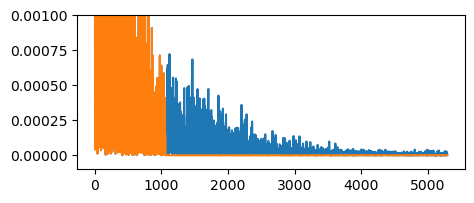

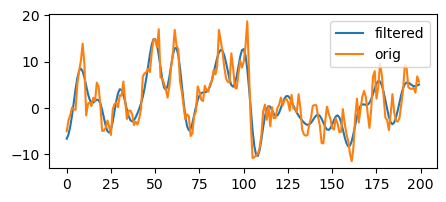

...Make sure this looks good!!


In [10]:
print('...testing band pass...')
Udo = np.array(DS_cera0['U'])

Udo.shape
ts_Udo = Udo[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
perd = 1/freq[1:]
val_8d, ind_8d = find_nearest(perd,value=7000)
print('index 8day:',ind_8d)
val_1d, ind_1d = find_nearest(perd,value=10)
print('index 1day:',ind_1d)

######################
#filter block...
ts_Udo = Udo[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
Ck2 = 2.*np.abs(Yfft[0:int(np.size(ts_Udo)/2)+1])**2 
# actual variance of our data
var_actual = np.var(ts_Udo)
# variance in our spectrum, it should be close to the actual variance of our data
a = Yfft[np.arange(0,int(np.size(ts_Udo)/2)+1)]
s=np.sum(a[1::]*np.conj(a[1::])) # don't want to include the mean, since this is not in the variance calculation
var_spectrum = np.real(2*s) # multiply by two in order to conserve variance
A = Ck2/np.sum(Ck2)
A[:ind_8d] = 0.
A[ind_1d:] = 0.
Zlow = np.copy(Z)
Zlow[:ind_8d] = 0.0
Zlow[ind_1d:-ind_1d] = 0.0
Zlow[-ind_8d:] = 0.0
print('number of non-zero values = ' + str(len(np.where(Zlow!=0)[0])))
# convert back to time space
X_filtered11 = np.real(np.fft.ifft(Zlow))
######################

######################
#filter block...
ts_Udo = Udo[:,30,30]
Z = np.fft.fft(ts_Udo)
Zlow = np.copy(Z)
# Zlow[:ind_8d] = 0.0
Zlow[ind_1d:-ind_1d] = 0.0
# Zlow[-ind_8d:] = 0.0
X_filtered = np.real(np.fft.ifft(Zlow))
print('number of non-zero values = ' + str(len(np.where(Zlow!=0)[0])))
# convert back to time space
X_filtered = np.real(np.fft.ifft(Zlow))
######################
plt.figure(figsize=(5,2))
plt.plot((Ck2/np.sum(Ck2))[1:])
plt.plot(A[1:])
plt.ylim(-.0001,.001)
plt.show()

plt.figure(figsize=(5,2))
plt.plot(X_filtered[:200],label='filtered')
plt.plot(ts_Udo[:200],label='orig')
plt.legend()
plt.show()
print("...Make sure this looks good!!")

## MORE Paper; Motivation

- On the modification of the high-and low-frequency eddies associated with the PNA anomaly: an observational study (and references there in)

- Dynamic Forcing of the Slow Transients by Synoptic-Scale Eddies: An Observational Study

## Add Band Pass, and Low Pass Filtered Data

In [11]:
%%time
print('...this will take forever...')
# this paper: https://link.springer.com/article/10.1007/s00382-010-0873-4
u_10d_90d_band = np.zeros_like(DS_cera0['U_mr'])
v_10d_90d_band = np.zeros_like(DS_cera0['V_mr'])
vrt_10d_90d_band = np.zeros_like(DS_cera0['vorticity_mr'])

u_2d_10d_band = np.zeros_like(DS_cera0['U_mr'])
v_2d_10d_band = np.zeros_like(DS_cera0['V_mr'])
vrt_2d_10d_band = np.zeros_like(DS_cera0['vorticity_mr'])

u_10d_low_band = np.zeros_like(DS_cera0['U_mr'])
v_10d_low_band = np.zeros_like(DS_cera0['V_mr'])
vrt_10d_low_band = np.zeros_like(DS_cera0['vorticity_mr'])

lat = DS_cera0['lat']
lon = DS_cera0['lon']

Udo = np.array(DS_cera0['U_mr'])
Vdo = np.array(DS_cera0['V_mr'])
VRTdo = np.array(DS_cera0['vorticity_mr'])

Udo_kp = np.array(DS_cera0['U'])
Vdo_kp = np.array(DS_cera0['V'])
VRTdo_kp = np.array(DS_cera0['vorticity'])

#This works because they are daily sampled values.
### +++ block to get frequencies

fs = 1 #day
ts_Udo = Udo[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
perd = fs/freq[1:]
val_8d, ind_8d = find_nearest(perd,value=10)
print('cutoff index 8day:',ind_8d)
val_1d, ind_1d = find_nearest(perd,value=1)
print('cutoff index 1day:',ind_1d)
val_20d, ind_20d = find_nearest(perd,value=7000)
print('cutoff index 20day:',ind_20d)
val_5d, ind_5d = find_nearest(perd,value=10)
print('cutoff index 5day:',ind_5d)

val_90d, ind_90d = find_nearest(perd,value=90)
print('cutoff index 90day:',ind_90d)
### --- block to get frequencies

for lala in range(lat.shape[0]):
    print(lala,'of: ',lat.shape[0])
    for lolo in range(lon.shape[0]):
        
        dU_km = Udo_kp[:,lala,lolo]
        dV_km = Vdo_kp[:,lala,lolo]
        dVrt_km = VRTdo_kp[:,lala,lolo]

        #U 10d_low
        Z = np.fft.fft(dU_km)
        Zlow = np.copy(Z)
        # Zlow[:ind_20d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        # Zlow[-ind_20d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        u_10d_low_band[:,lala,lolo]=X_filtered

        #V 10d_low
        Z = np.fft.fft(dV_km)
        Zlow = np.copy(Z)
        # Zlow[:ind_20d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        # Zlow[-ind_20d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        v_10d_low_band[:,lala,lolo]=X_filtered

        #Vrt 10d_low
        Z = np.fft.fft(dVrt_km)
        Zlow = np.copy(Z)
        # Zlow[:ind_20d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        # Zlow[-ind_20d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vrt_10d_low_band[:,lala,lolo]=X_filtered

print('..done band loop..')
C_filt = xr.Dataset(
        {
            "u_10d_low_band": (["time","lat", "lon"],u_10d_low_band),
            "v_10d_low_band": (["time","lat", "lon"],v_10d_low_band),
            "vrt_10d_low_band": (["time","lat", "lon"],vrt_10d_low_band),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

C_filt.attrs["title"] = "CESM UV Forecast band pass and low pass winds at 200mb"
C_filt.u_10d_low_band.attrs['units'] = 'm s**-1'
C_filt.u_10d_low_band.attrs['standard_name']='10d low pass Zonal Wind'
C_filt.u_10d_low_band.attrs['long_name']='10d low pass Zonal Wind'
C_filt.v_10d_low_band.attrs['units'] = 'm s**-1'
C_filt.v_10d_low_band.attrs['standard_name']='10d low pass Meridional Wind'
C_filt.v_10d_low_band.attrs['long_name']='10d low pass Meridional Wind'

print('...merging...')
DS_cera0 = xr.merge([DS_cera0,C_filt])
DS_cera0

...this will take forever...
cutoff index 8day: 1058
cutoff index 1day: 5295
cutoff index 20day: 1
cutoff index 5day: 1058
cutoff index 90day: 117
0 of:  73
1 of:  73
2 of:  73
3 of:  73
4 of:  73
5 of:  73
6 of:  73
7 of:  73
8 of:  73
9 of:  73
10 of:  73
11 of:  73
12 of:  73
13 of:  73
14 of:  73
15 of:  73
16 of:  73
17 of:  73
18 of:  73
19 of:  73
20 of:  73
21 of:  73
22 of:  73
23 of:  73
24 of:  73
25 of:  73
26 of:  73
27 of:  73
28 of:  73
29 of:  73
30 of:  73
31 of:  73
32 of:  73
33 of:  73
34 of:  73
35 of:  73
36 of:  73
37 of:  73
38 of:  73
39 of:  73
40 of:  73
41 of:  73
42 of:  73
43 of:  73
44 of:  73
45 of:  73
46 of:  73
47 of:  73
48 of:  73
49 of:  73
50 of:  73
51 of:  73
52 of:  73
53 of:  73
54 of:  73
55 of:  73
56 of:  73
57 of:  73
58 of:  73
59 of:  73
60 of:  73
61 of:  73
62 of:  73
63 of:  73
64 of:  73
65 of:  73
66 of:  73
67 of:  73
68 of:  73
69 of:  73
70 of:  73
71 of:  73
72 of:  73
..done band loop..
...merging...
CPU times: user 31.5 s, sys

<xarray.Dataset>
Dimensions:           (time: 10593, lat: 73, lon: 144)
Coordinates:
    lev               float64 524.7
  * time              (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2011-01-01
  * lat               (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon               (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    V                 (time, lat, lon) float32 2.868 2.868 2.868 ... 3.66 3.66
    U                 (time, lat, lon) float32 4.193 4.193 4.193 ... 1.768 1.768
    U_mr              (time, lat, lon) float32 4.534 4.534 ... 0.2923 0.2923
    V_mr              (time, lat, lon) float32 1.506 1.506 1.506 ... 6.233 6.233
    vorticity         (time, lat, lon) float32 9.196e-06 ... -1.584e-05
    psi               (time, lat, lon) float32 -5.82e+07 -5.82e+07 ... 6.783e+07
    vorticity_mr      (time, lat, lon) float32 4.299e-06 ... -1.655e-05
    psi_mr            (time, lat, lon) float32 8.854e+06 8.854e+06 ... 9.325e+05
    u_10d_low_band    (time, lat, lon) float32 3.473 3.473 ... -0.2827 -0.2827
    v_10d_low_band    (time, lat, lon) float32 -2.918 -2.918 ... 1.492 1.492
    vrt_10d_low_band  (time, lat, lon) float32 1.951e-05 ... -9.833e-06
Attributes:
    regrid_method:  bilinear

## Get Climo

... creating climo from centered 30 day average ...
doing  0  of 365
doing  20  of 365
doing  40  of 365
doing  60  of 365
doing  80  of 365
doing  100  of 365
doing  120  of 365
doing  140  of 365
doing  160  of 365
doing  180  of 365
doing  200  of 365
doing  220  of 365
doing  240  of 365
doing  260  of 365
doing  280  of 365
doing  300  of 365
doing  320  of 365
doing  340  of 365
doing  360  of 365
...now repeating climo...
doing  0  of  10593
doing  1000  of  10593
doing  2000  of  10593
doing  3000  of  10593
doing  4000  of  10593
doing  5000  of  10593
doing  6000  of  10593
doing  7000  of  10593
doing  8000  of  10593
doing  9000  of  10593
doing  10000  of  10593
...computing remaining terms...


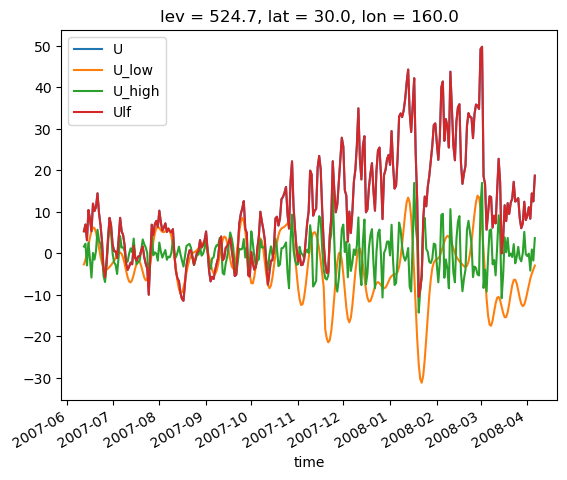

.. MAKE SURE THIS LOOKS GOOD!!!!
CPU times: user 4min 1s, sys: 2min 10s, total: 6min 12s
Wall time: 6min 11s


In [12]:
%%time
U_climo = xr.zeros_like(DS_cera0['U'])
V_climo = xr.zeros_like(DS_cera0['U'])
vrt_climo = xr.zeros_like(DS_cera0['U'])
print('... creating climo from centered 30 day average ...')
for ee,dayhr in (enumerate(pd.date_range(start=DS_cera0['time'][0].values,end=DS_cera0['time'][-1].values)[:-1])):
    if ee%20 ==0:
        print('doing ',ee,' of 365')
    dooDOY = dayhr.dayofyear
    hh=dayhr.hour
    Dtemp = DS_cera0.sel(time=is_doyrange(DS_cera0['time.dayofyear'],dooDOY,DS_cera0['time.hour'],hh))[['U','V','vorticity']].mean(['time'])
    U_climo[ee,:,:] = Dtemp['U'].values
    V_climo[ee,:,:] = Dtemp['V'].values
    vrt_climo[ee,:,:] = Dtemp['vorticity'].values
    
    if ee == (365)+11:
        endee=ee
        enddate = dayhr
        break
print('...now repeating climo...') 
for ee,dayhr in (enumerate(pd.date_range(start=enddate,end=DS_cera0['time'][-1].values)[:-1])):
    getday = str(DS_cera0['time.year'][0].values)+'-'+f'{dayhr.month:02}'+'-'+f'{dayhr.day:02}'
    
    #leap year shenanigans:
    if f'{dayhr.month:02}'+'-'+f'{dayhr.day:02}' == '02-29': 
        getday = str(DS_cera0['time.year'][0].values)+'-02-28'
        
    if ee%1000 ==0:
        print('doing ',ee,' of ', len(DS_cera0['time']))
        
    DtempU = U_climo.sel(time=getday)
    DtempV = V_climo.sel(time=getday)
    Dtempvrt = vrt_climo.sel(time=getday)
       
    U_climo[ee+endee+1,:,:] = DtempU.values
    V_climo[ee+endee+1,:,:] = DtempV.values
    vrt_climo[ee+endee+1,:,:] = Dtempvrt.values

print('...computing remaining terms...')
DS_cera0['U_climo'] = U_climo   
DS_cera0['V_climo'] = V_climo   
DS_cera0['vrt_climo'] = vrt_climo

DS_cera0['u_2d_10d_band'] = DS_cera0['U']-DS_cera0['u_10d_low_band']
DS_cera0['v_2d_10d_band'] = DS_cera0['V']-DS_cera0['v_10d_low_band']

DS_cera0['u_10d_90d_band'] = DS_cera0['u_10d_low_band']-DS_cera0['U_climo']
DS_cera0['v_10d_90d_band'] = DS_cera0['v_10d_low_band']-DS_cera0['V_climo']

DS_cera0['vort_lf'] = vorticity(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])
DS_cera0['vort_hf'] = vorticity(DS_cera0['u_2d_10d_band'],DS_cera0['v_2d_10d_band'])
DS_cera0['vrt_2d_10d_band'] = vorticity(DS_cera0['u_2d_10d_band'],DS_cera0['v_2d_10d_band'])
DS_cera0['vrt_10d_90d_band'] = vorticity(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])
DS_cera0['vrt_climo'] = vorticity(DS_cera0['U_climo'],DS_cera0['V_climo'])

DS_cera0['U'].sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='U')
DS_cera0['u_10d_90d_band'].sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='U_low')
DS_cera0['u_2d_10d_band'].sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='U_high')
(DS_cera0['u_10d_90d_band']+DS_cera0['u_2d_10d_band']+DS_cera0['U_climo']).sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='Ulf')
plt.legend()
plt.show()
print('.. MAKE SURE THIS LOOKS GOOD!!!!')

## Compute the Rotational and Divergent Components of the wind

In [13]:
%%time
DS_cera0['uwnd_hf_r'],DS_cera0['vwnd_hf_r'] = rotational(DS_cera0['u_2d_10d_band'],DS_cera0['v_2d_10d_band'])
print('1')
DS_cera0['uwnd_hf_d'],DS_cera0['vwnd_hf_d'] = divergent(DS_cera0['u_2d_10d_band'],DS_cera0['v_2d_10d_band'])
print('2')
DS_cera0['uwnd_lf_r'],DS_cera0['vwnd_lf_r'] = rotational(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])
print('3')
DS_cera0['uwnd_lf_d'],DS_cera0['vwnd_lf_d'] = divergent(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])
print('...done...')
DS_cera0

1
2
3
...done...
CPU times: user 1min 46s, sys: 11 s, total: 1min 57s
Wall time: 1min 57s


<xarray.Dataset>
Dimensions:           (time: 10593, lat: 73, lon: 144)
Coordinates:
    lev               float64 524.7
  * time              (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2011-01-01
  * lat               (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon               (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables: (12/30)
    V                 (time, lat, lon) float32 2.868 2.868 2.868 ... 3.66 3.66
    U                 (time, lat, lon) float32 4.193 4.193 4.193 ... 1.768 1.768
    U_mr              (time, lat, lon) float32 4.534 4.534 ... 0.2923 0.2923
    V_mr              (time, lat, lon) float32 1.506 1.506 1.506 ... 6.233 6.233
    vorticity         (time, lat, lon) float32 9.196e-06 ... -1.584e-05
    psi               (time, lat, lon) float32 -5.82e+07 -5.82e+07 ... 6.783e+07
    ...                ...
    uwnd_hf_d         (time, lat, lon) float32 -0.4826 -0.6176 ... -0.6523
    vwnd_hf_d         (time, lat, lon) float32 -3.106 -3.082 ... -1.018 -1.047
    uwnd_lf_r         (time, lat, lon) float32 2.004 1.889 ... 0.05661 -0.01766
    vwnd_lf_r         (time, lat, lon) float32 -2.607 -2.692 ... 1.702 1.702
    uwnd_lf_d         (time, lat, lon) float32 -1.736 -1.631 ... 0.03108
    vwnd_lf_d         (time, lat, lon) float32 2.383 2.456 ... -1.518 -1.518
Attributes:
    regrid_method:  bilinear

## Rotational and Divergent Components of the Climatology

In [14]:
%%time
DS_cera0['U_climo_r'],DS_cera0['V_climo_r'] = rotational(DS_cera0['U_climo'],DS_cera0['V_climo'])
print('1')
DS_cera0['U_climo_d'],DS_cera0['V_climo_d'] = divergent(DS_cera0['U_climo'],DS_cera0['V_climo'])
print('...done...')

1
...done...
CPU times: user 53.3 s, sys: 5.42 s, total: 58.7 s
Wall time: 58.6 s


## Compute the Zonally Symmetric, Zonally Asymmetric Components of the Wind

In [15]:
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
DS_cera0['absvrt_climo'] = DS_cera0['vrt_climo']+pvrt

In [16]:
%%time
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
DS_cera0['absvrt_climo'] = DS_cera0['vrt_climo']+pvrt

##zonally symmetric
uwnd_clm_zm_r = xr.zeros_like(DS_cera0['U_climo_r'])+DS_cera0['U_climo_r'].mean('lon')
uwnd_clm_zm_d = xr.zeros_like(DS_cera0['U_climo_d'])+DS_cera0['U_climo_d'].mean('lon')
vwnd_clm_zm_r = xr.zeros_like(DS_cera0['V_climo_r'])+DS_cera0['V_climo_r'].mean('lon')
vwnd_clm_zm_d = xr.zeros_like(DS_cera0['V_climo_d'])+DS_cera0['V_climo_d'].mean('lon')
vort_clm_zm = xr.zeros_like(DS_cera0['vrt_climo'])+DS_cera0['vrt_climo'].mean('lon')
absvort_clm_zm = xr.zeros_like(DS_cera0['absvrt_climo'])+DS_cera0['absvrt_climo'].mean('lon')
uwnd_clm_zm = xr.zeros_like(DS_cera0['U_climo'])+DS_cera0['U_climo'].mean('lon')
vwnd_clm_zm = xr.zeros_like(DS_cera0['V_climo'])+DS_cera0['V_climo'].mean('lon')


DS_cera0['uwnd_clm_zm_r'] = uwnd_clm_zm_r
DS_cera0['uwnd_clm_zm_d'] = uwnd_clm_zm_d
DS_cera0['vwnd_clm_zm_r'] = vwnd_clm_zm_r
DS_cera0['vwnd_clm_zm_d'] = vwnd_clm_zm_d
DS_cera0['vort_clm_zm'] = vort_clm_zm
DS_cera0['absvort_clm_zm'] = absvort_clm_zm
DS_cera0['uwnd_clm_zm'] = uwnd_clm_zm
DS_cera0['vwnd_clm_zm'] = vwnd_clm_zm

##zonally asymmetric
uwnd_clm_sw_r = DS_cera0['U_climo_r'] - DS_cera0['U_climo_r'].mean('lon')
uwnd_clm_sw_d = DS_cera0['U_climo_d'] - DS_cera0['U_climo_d'].mean('lon')
vwnd_clm_sw_r = DS_cera0['V_climo_r'] - DS_cera0['V_climo_r'].mean('lon')
vwnd_clm_sw_d = DS_cera0['V_climo_d'] - DS_cera0['V_climo_d'].mean('lon')
vort_clm_sw = DS_cera0['vrt_climo'] - DS_cera0['vrt_climo'].mean('lon')
absvort_clm_sw = DS_cera0['absvrt_climo'] - DS_cera0['absvrt_climo'].mean('lon')
uwnd_clm_sw = DS_cera0['U_climo'] - DS_cera0['U_climo'].mean('lon')
vwnd_clm_sw = DS_cera0['V_climo'] - DS_cera0['V_climo'].mean('lon')


DS_cera0['uwnd_clm_sw_r'] = uwnd_clm_sw_r
DS_cera0['uwnd_clm_sw_d'] = uwnd_clm_sw_d
DS_cera0['vwnd_clm_sw_r'] = vwnd_clm_sw_r
DS_cera0['vwnd_clm_sw_d'] = vwnd_clm_sw_d
DS_cera0['vort_clm_sw'] = vort_clm_sw
DS_cera0['absvort_clm_sw'] = absvort_clm_sw
DS_cera0['uwnd_clm_sw'] = uwnd_clm_sw
DS_cera0['vwnd_clm_sw'] = vwnd_clm_sw


DS_cera0['lat'].attrs["units"] = 'degrees_N'
DS_cera0['lon'].attrs["units"] = 'degrees_E'
print('...saving...')
DS_cera0.to_netcdf(tot_out,format="NETCDF4_CLASSIC")

...saving...
CPU times: user 11.6 s, sys: 13 s, total: 24.6 s
Wall time: 28 s


## Save a smaller DS to test your NCL code

In [17]:
DStrain = DS_cera0.isel(time=slice(0,389))
DStrain['time']=pd.date_range('1979-01-01','1980-01-24')
# DStrain.to_netcdf(file_path+modvers_comp + '_'+str(lev)+'mb_'+'High_Low_Pass_SUBSEASONAL_TAN_small_v3.nc',format="NETCDF4_CLASSIC")

## Check your Filtering
- Does the low pass + high pass + climatology = the original TS? 

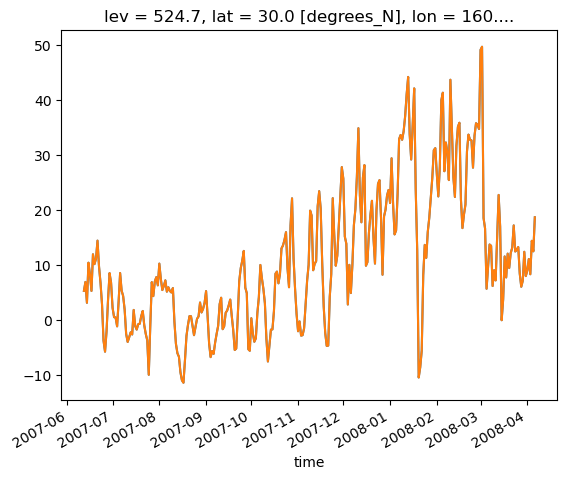

.. MAKE SURE THIS LOOKS GOOD!!!!


In [18]:
DS_cera0['U'].sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='U')
(DS_cera0['u_10d_90d_band']+DS_cera0['u_2d_10d_band']+DS_cera0['U_climo']).sel(lat=30,lon=160,method='nearest').isel(time=slice(-1300,-1000)).plot(label='Ulf')
plt.show()
print('.. MAKE SURE THIS LOOKS GOOD!!!!')

## Calc Tan et al Equation
- get cross terms
- Low Pass Filter the new terms


In [19]:
%%time
pvrt = w.planetaryvorticity()
DS_cera0["uH_vrtH"]=DS_cera0["vrt_2d_10d_band"]*DS_cera0["u_2d_10d_band"]
DS_cera0["vH_vrtH"]=DS_cera0["vrt_2d_10d_band"]*DS_cera0["v_2d_10d_band"]

DS_cera0["uL_vrtL"]=DS_cera0["u_10d_90d_band"]*DS_cera0["vrt_10d_90d_band"]
DS_cera0["vL_vrtL"]=DS_cera0["v_10d_90d_band"]*DS_cera0["vrt_10d_90d_band"]

DS_cera0["uL_absVrt_p_vrtL_uclim"]=(DS_cera0["u_10d_90d_band"]*(pvrt+DS_cera0['vrt_climo'])) +(DS_cera0['vrt_10d_90d_band']*DS_cera0["U_climo"])
DS_cera0["vL_absVrt_p_vrtL_vclim"]=(DS_cera0["v_10d_90d_band"]*(pvrt+DS_cera0['vrt_climo'])) +(DS_cera0['vrt_10d_90d_band']*DS_cera0["V_climo"])

DS_cera0["uL_absVrt"]=(DS_cera0["u_10d_90d_band"]*(pvrt+DS_cera0['vrt_climo']))
DS_cera0["vL_absVrt"]=(DS_cera0["v_10d_90d_band"]*(pvrt+DS_cera0['vrt_climo'])) 

DS_cera0["vrtL_uclim"]=(DS_cera0['vrt_10d_90d_band']*DS_cera0["U_climo"])
DS_cera0["vrtL_vclim"]=(DS_cera0['vrt_10d_90d_band']*DS_cera0["V_climo"])


##filtering
uH_vrtH_L = np.zeros_like(DS_cera0['V']) 
vH_vrtH_L = np.zeros_like(DS_cera0['V'])

uL_vrtH_L = np.zeros_like(DS_cera0['V'])
vL_vrtH_L = np.zeros_like(DS_cera0['V'])

uL_vrtL_L = np.zeros_like(DS_cera0['V'])
vL_vrtL_L = np.zeros_like(DS_cera0['V'])

uL_absVrt_p_vrtL_uclim_L = np.zeros_like(DS_cera0['V'])
vL_absVrt_p_vrtL_vclim_L = np.zeros_like(DS_cera0['V'])

uL_absVrt_L = np.zeros_like(DS_cera0['V'])
vL_absVrt_L = np.zeros_like(DS_cera0['V'])
vrtL_uclim_L = np.zeros_like(DS_cera0['V'])
vrtL_vclim_L = np.zeros_like(DS_cera0['V'])


uH_vrtH = np.array(DS_cera0['uH_vrtH'])
vH_vrtH = np.array(DS_cera0['vH_vrtH'])
uL_vrtL = np.array(DS_cera0['uL_vrtL'])
vL_vrtL = np.array(DS_cera0['vL_vrtL'])
uL_absVrt_p_vrtL_uclim = np.array(DS_cera0['uL_absVrt_p_vrtL_uclim'])
vL_absVrt_p_vrtL_vclim = np.array(DS_cera0['vL_absVrt_p_vrtL_vclim'])

uL_absVrt = np.array(DS_cera0["uL_absVrt"]) 
vL_absVrt = np.array(DS_cera0["vL_absVrt"])
vrtL_uclim = np.array(DS_cera0["vrtL_uclim"])
vrtL_vclim = np.array(DS_cera0["vrtL_vclim"]) 

for lala in range(lat.shape[0]):
    print(lala,'of: ',lat.shape[0])
    for lolo in range(lon.shape[0]):
        duH_vrtH=uH_vrtH[:,lala,lolo]
        dvH_vrtH=vH_vrtH[:,lala,lolo]
        duL_vrtL=uL_vrtL[:,lala,lolo]
        dvL_vrtL=vL_vrtL[:,lala,lolo]
        duL_absVrt_p_vrtL_uclim=uL_absVrt_p_vrtL_uclim[:,lala,lolo]
        dvL_absVrt_p_vrtL_vclim=vL_absVrt_p_vrtL_vclim[:,lala,lolo]
        
        duL_absVrt = uL_absVrt[:,lala,lolo]
        dvL_absVrt = vL_absVrt[:,lala,lolo]
        dvrtL_uclim = vrtL_uclim[:,lala,lolo]
        dvrtL_vclim = vrtL_vclim[:,lala,lolo]
        
        #uH_vrtH 10d-90d
        Z = np.fft.fft(duH_vrtH)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        uH_vrtH_L[:,lala,lolo]=X_filtered
        
        #vH_vrtH 10d-90d
        Z = np.fft.fft(dvH_vrtH)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vH_vrtH_L[:,lala,lolo]=X_filtered
        
        
        #uL_vrtL 10d-90d
        Z = np.fft.fft(duL_vrtL)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        uL_vrtL_L[:,lala,lolo]=X_filtered
        
        #vL_vrtL 10d-90d
        Z = np.fft.fft(dvL_vrtL)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vL_vrtL_L[:,lala,lolo]=X_filtered
        
        
        #uL_absVrt_p_vrtL_uclim 10d-90d
        Z = np.fft.fft(duL_absVrt_p_vrtL_uclim)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        uL_absVrt_p_vrtL_uclim_L[:,lala,lolo]=X_filtered
        
        #vL_absVrt_p_vrtL_vclim 10d-90d
        Z = np.fft.fft(dvL_absVrt_p_vrtL_vclim)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vL_absVrt_p_vrtL_vclim_L[:,lala,lolo]=X_filtered
        
        #uL_absVrt 10d-90d
        Z = np.fft.fft(duL_absVrt)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        uL_absVrt_L[:,lala,lolo]=X_filtered
        
        #vL_absVrt 10d-90d
        Z = np.fft.fft(dvL_absVrt)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vL_absVrt_L[:,lala,lolo]=X_filtered
        
        #vrtL_uclim 10d-90d
        Z = np.fft.fft(dvrtL_uclim)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vrtL_uclim_L[:,lala,lolo]=X_filtered
        
        #vrtL_vclim 10d-90d
        Z = np.fft.fft(dvrtL_vclim)
        Zlow = np.copy(Z)
        Zlow[:ind_90d] = 0.0
        Zlow[ind_5d:-ind_5d] = 0.0
        Zlow[-ind_90d:] = 0.0
        X_filtered = np.real(np.fft.ifft(Zlow))
        vrtL_vclim_L[:,lala,lolo]=X_filtered
        
C_filt3 = xr.Dataset(
        {
            "uH_vrtH_L": (["time","lat", "lon"],uH_vrtH_L),
            "vH_vrtH_L": (["time","lat", "lon"],vH_vrtH_L),
            "uL_vrtL_L": (["time","lat", "lon"],uL_vrtL_L),
            "vL_vrtL_L": (["time","lat", "lon"],vL_vrtL_L),
            "uL_absVrt_p_vrtL_uclim_L": (["time","lat", "lon"],uL_absVrt_p_vrtL_uclim_L),
            "vL_absVrt_p_vrtL_vclim_L": (["time","lat", "lon"],vL_absVrt_p_vrtL_vclim_L),
            "uL_absVrt_L": (["time","lat", "lon"],uL_absVrt_L),
            "vL_absVrt_L": (["time","lat", "lon"],vL_absVrt_L),
            "vrtL_uclim_L": (["time","lat", "lon"],vrtL_uclim_L),
            "vrtL_vclim_L": (["time","lat", "lon"],vrtL_vclim_L),
            
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

DS_cera0 = xr.merge([DS_cera0,C_filt3])
DS_cera0

print('...saving...')
DS_cera0.to_netcdf(tot_out,format="NETCDF4_CLASSIC")

0 of:  73
1 of:  73
2 of:  73
3 of:  73
4 of:  73
5 of:  73
6 of:  73
7 of:  73
8 of:  73
9 of:  73
10 of:  73
11 of:  73
12 of:  73
13 of:  73
14 of:  73
15 of:  73
16 of:  73
17 of:  73
18 of:  73
19 of:  73
20 of:  73
21 of:  73
22 of:  73
23 of:  73
24 of:  73
25 of:  73
26 of:  73
27 of:  73
28 of:  73
29 of:  73
30 of:  73
31 of:  73
32 of:  73
33 of:  73
34 of:  73
35 of:  73
36 of:  73
37 of:  73
38 of:  73
39 of:  73
40 of:  73
41 of:  73
42 of:  73
43 of:  73
44 of:  73
45 of:  73
46 of:  73
47 of:  73
48 of:  73
49 of:  73
50 of:  73
51 of:  73
52 of:  73
53 of:  73
54 of:  73
55 of:  73
56 of:  73
57 of:  73
58 of:  73
59 of:  73
60 of:  73
61 of:  73
62 of:  73
63 of:  73
64 of:  73
65 of:  73
66 of:  73
67 of:  73
68 of:  73
69 of:  73
70 of:  73
71 of:  73
72 of:  73
...saving...
CPU times: user 1min 56s, sys: 15 s, total: 2min 11s
Wall time: 2min 14s


## Calculate the Tan Forcing Tendency
Tan et al (2017). The Role of Synoptic Waves in the Formation and Maintenance of the Western Hemisphere Circulation Pattern (https://doi.org/10.1175/JCLI-D-17-0158.1) (EQ. 4-6)
- Term 1 = T1 
- Term 2 = T2
- Term 3 = T3 


The *Linear* term is 'T3' and is the true decomposition from the vorticity equation.. it is important to check any further decomp against this term. I have found that the spectral gradients as prevent me from decomposing into assymetric and symmetric components of the wind without sacrificing accuracy. 


-- the big issue I find is that divergence in spectral space is different than du/dx + dv/dy

term1
term2
..term3 done..
..term3_1 done..
..term3_2 done..
cutoff index : 1058
..term3_2_1 done..
..term3_2_2 done..
..term3_2_3 done..
..term3_2_4 done..
saved..: /glade/scratch/wchapman/DA_ML_data/Random_Data/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982_500mb_High_Low_Pass_SUBSEASONAL_TAN_longer_climo_consistent.nc


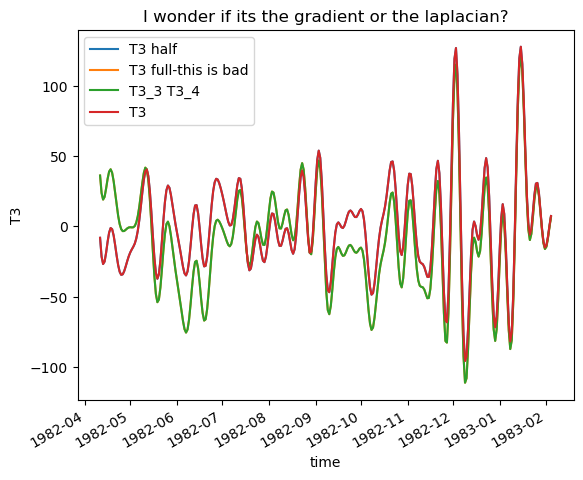

CPU times: user 5min 46s, sys: 34.4 s, total: 6min 20s
Wall time: 6min 23s


In [20]:
%%time
##term1
div_get = -1*divy(DS_cera0['uH_vrtH_L'],DS_cera0['vH_vrtH_L'])
div_get = div_get.to_dataset(name='grad_dot_VhvrtH_L')
divdd = Inv_lap(DS_cera0,div_get['grad_dot_VhvrtH_L'])
divdd = divdd.rename({'grad_dot_VhvrtH_L_invlap':'T1'})
DS_cera0 = xr.merge([DS_cera0,divdd])
print('term1')

##term2
div_get = -1*divy(DS_cera0['uL_vrtL_L'],DS_cera0['vL_vrtL_L'])
div_get = div_get.to_dataset(name='grad_dot_VlvrtL_L')
divdd = Inv_lap(DS_cera0,div_get['grad_dot_VlvrtL_L'])
divdd = divdd.rename({'grad_dot_VlvrtL_L_invlap':'T2'})
DS_cera0 = xr.merge([DS_cera0,divdd])
print('term2')

##term3
div_get=-1*divy(DS_cera0['uL_absVrt_p_vrtL_uclim_L'],DS_cera0['vL_absVrt_p_vrtL_vclim_L'])
div_get = div_get.to_dataset(name='grad_dot_VL_absVrt_p_vrtL_Vclim_L')
divdd = Inv_lap(DS_cera0,div_get['grad_dot_VL_absVrt_p_vrtL_Vclim_L'])
divdd = divdd.rename({'grad_dot_VL_absVrt_p_vrtL_Vclim_L_invlap':'T3'})
DS_cera0 = xr.merge([DS_cera0,divdd])
print('..term3 done..')
divdd = Inv_lap(DS_cera0,-1*DS_cera0['vort_lf'])
DS_cera0 = xr.merge([DS_cera0,divdd])

##term3_1 climatological absolute vorticity advection by the low-frequency wind anomaly
div_get=-1*divy(DS_cera0['uL_absVrt_L'],DS_cera0['vL_absVrt_L'])
div_get = div_get.to_dataset(name='grad_dot_VL_absVrt_L')
divdd = Inv_lap(DS_cera0,div_get['grad_dot_VL_absVrt_L'])
divdd = divdd.rename({'grad_dot_VL_absVrt_L_invlap':'T3_1'})
DS_cera0 = xr.merge([DS_cera0,divdd])
print('..term3_1 done..')
DS_cera0 = xr.merge([DS_cera0,divdd])

##term3_2 low-frequency eddy vorticity advection by the climatological wind CLIO
div_get=-1*divy(DS_cera0['vrtL_uclim_L'],DS_cera0['vrtL_vclim_L'])
div_get = div_get.to_dataset(name='grad_dot_vrtL_Vclim_L')
divdd = Inv_lap(DS_cera0,div_get['grad_dot_vrtL_Vclim_L'])
divdd = divdd.rename({'grad_dot_vrtL_Vclim_L_invlap':'T3_2'})
DS_cera0 = xr.merge([DS_cera0,divdd])
print('..term3_2 done..')

## Term 3_2_1
grad_vort_lf_x , grad_vort_lf_y = w.gradient(DS_cera0['vort_lf'])
grad_absvort_clm_zm_x , grad_absvort_clm_zm_y = w.gradient(DS_cera0['absvort_clm_zm'])


term3_2_1_fst = (- DS_cera0['uwnd_clm_zm'] * grad_vort_lf_x - DS_cera0['vwnd_clm_zm'] * grad_vort_lf_y \
            - DS_cera0['u_10d_90d_band'] * grad_absvort_clm_zm_x - DS_cera0['v_10d_90d_band'] * grad_absvort_clm_zm_y).to_dataset(name='term3_2_1_fst')
  
##low pass:
tsindy = np.array(term3_2_1_fst['term3_2_1_fst'].sel(lat=30,lon=200,method='nearest'))
Z = np.fft.fft(tsindy)
Yfft = Z/np.size(tsindy)
freq = np.fft.rfftfreq(len(tsindy))
fs = 1 #day
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index :',ind_10d)
term3_2_1_fst_lp = low_pass_DA(term3_2_1_fst['term3_2_1_fst'],ind_10d).to_dataset(name='term3_2_1_fst')
print('..term3_2_1 done..')
####    

ilap_term3_2_1_fst = Inv_lap(DS_cera0,term3_2_1_fst_lp['term3_2_1_fst'])
ilap_T3_2_1 = (ilap_term3_2_1_fst['term3_2_1_fst_invlap']).to_dataset(name='T3_2_1')
## Term 3_2_1

## Term 3_2_2
grad_vort_lf_x , grad_vort_lf_y = w.gradient(DS_cera0['vort_lf'])
grad_absvort_clm_sw_x , grad_absvort_clm_sw_y = w.gradient(DS_cera0['absvort_clm_sw'])

term3_2_2_fst = (- DS_cera0['uwnd_clm_sw'] * grad_vort_lf_x - DS_cera0['vwnd_clm_sw'] * grad_vort_lf_y\
                - DS_cera0['u_10d_90d_band'] * grad_absvort_clm_sw_x - DS_cera0['v_10d_90d_band'] * grad_absvort_clm_sw_y).to_dataset(name='term3_2_2_fst')

term3_2_2_fst_lp = low_pass_DA(term3_2_2_fst['term3_2_2_fst'],ind_10d).to_dataset(name='term3_2_2_fst')
ilap_term3_2_2_fst = Inv_lap(DS_cera0,term3_2_2_fst_lp['term3_2_2_fst'])

ilap_T3_2_2 = (ilap_term3_2_2_fst['term3_2_2_fst_invlap']).to_dataset(name='T3_2_2')
print('..term3_2_2 done..')
## Term 3_2_2

## Term 3_2_3
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
term3_2_3_fst = (- (pvrt + DS_cera0['vrt_climo']) * divy(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])).to_dataset(name='term3_2_3_fst')
term3_2_3_snd = (- DS_cera0['vort_lf'] * divy((DS_cera0['U_climo']), (DS_cera0['V_climo']))).to_dataset(name='term3_2_3_snd')


term3_2_3_fst_lp = low_pass_DA(term3_2_3_fst['term3_2_3_fst'],ind_10d).to_dataset(name='term3_2_3_fst')
ilap_term3_2_3_fst = Inv_lap(DS_cera0,term3_2_3_fst_lp['term3_2_3_fst'])
term3_2_3_snd_lp = low_pass_DA(term3_2_3_snd['term3_2_3_snd'],ind_10d).to_dataset(name='term3_2_3_snd')
ilap_term3_2_3_snd = Inv_lap(DS_cera0,term3_2_3_snd_lp['term3_2_3_snd'])

ilap_term3_2_3_fst = Inv_lap(DS_cera0,term3_2_3_fst_lp['term3_2_3_fst'])
ilap_term3_2_3_snd = Inv_lap(DS_cera0,term3_2_3_snd_lp['term3_2_3_snd'])

ilap_T3_2_3 = (ilap_term3_2_3_fst['term3_2_3_fst_invlap']+ilap_term3_2_3_snd['term3_2_3_snd_invlap']).to_dataset(name='T3_2_3')
print('..term3_2_3 done..')
## Term 3_2_3

## Term 3_2_4
grad_vort_lf_x , grad_vort_lf_y = w.gradient(DS_cera0['vort_lf'])
grad_absvort_clm_x , grad_absvort_clm_y = w.gradient(DS_cera0['absvrt_climo'])

term3_2_4_fst = (- DS_cera0['U_climo'] * grad_vort_lf_x - DS_cera0['V_climo'] * grad_vort_lf_y\
                - DS_cera0['u_10d_90d_band'] * grad_absvort_clm_x - DS_cera0['v_10d_90d_band'] * grad_absvort_clm_y).to_dataset(name='term3_2_4_fst')

term3_2_4_fst_lp = low_pass_DA(term3_2_4_fst['term3_2_4_fst'],ind_10d).to_dataset(name='term3_2_4_fst')
ilap_term3_2_4_fst = Inv_lap(DS_cera0,term3_2_4_fst_lp['term3_2_4_fst'])

ilap_T3_2_4 = (ilap_term3_2_4_fst['term3_2_4_fst_invlap']).to_dataset(name='T3_2_4')
print('..term3_2_4 done..')
## Term 3_2_4

#merge it 
DS_cera0 = xr.merge([DS_cera0,ilap_T3_2_1,ilap_T3_2_2,ilap_T3_2_3,ilap_T3_2_4])


DS_cera0.to_netcdf(tot_out,format="NETCDF4_CLASSIC")
print('saved..:',tot_out)
(DS_cera0['T3_1']+DS_cera0['T3_2']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3 half')
(DS_cera0['T3_2_1']+DS_cera0['T3_2_2']+DS_cera0['T3_2_3']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3 full-this is bad')
(DS_cera0['T3_2_3']+DS_cera0['T3_2_4']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_3 T3_4')
# (DS_cera0['T3_2_5']+DS_cera0['T3_2_6']+DS_cera0['T3_2_7']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_2_567')
((DS_cera0['T3']).sel(lat=30,lon=200).isel(time=slice(100,400))).plot(label='T3')
plt.title('I wonder if its the gradient or the laplacian?')
plt.legend()
plt.show()

saved..: /glade/scratch/wchapman/DA_ML_data/Random_Data/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982_500mb_High_Low_Pass_SUBSEASONAL_TAN_longer_climo_consistent.nc


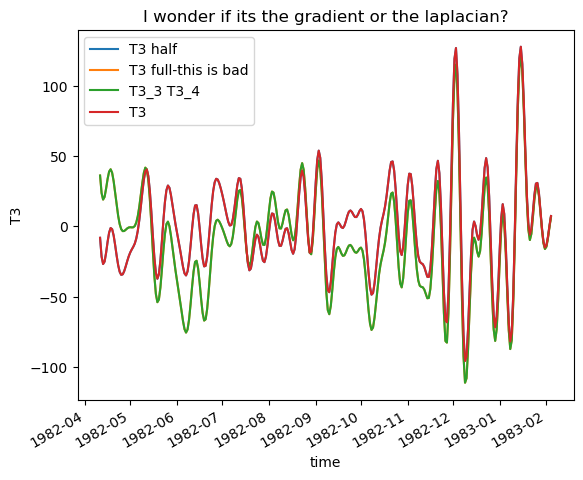

In [21]:
print('saved..:',tot_out)
(DS_cera0['T3_1']+DS_cera0['T3_2']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3 half')
(DS_cera0['T3_2_1']+DS_cera0['T3_2_2']+DS_cera0['T3_2_3']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3 full-this is bad')
(DS_cera0['T3_2_3']+DS_cera0['T3_2_4']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_3 T3_4')
# (DS_cera0['T3_2_5']+DS_cera0['T3_2_6']+DS_cera0['T3_2_7']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_2_567')
((DS_cera0['T3']).sel(lat=30,lon=200).isel(time=slice(100,400))).plot(label='T3')
plt.title('I wonder if its the gradient or the laplacian?')
plt.legend()
plt.show()

## More Tan Components

..term3_2_5 done..
..term3_2_6 done..
cutoff index : 1058
..term3_2_7 done..


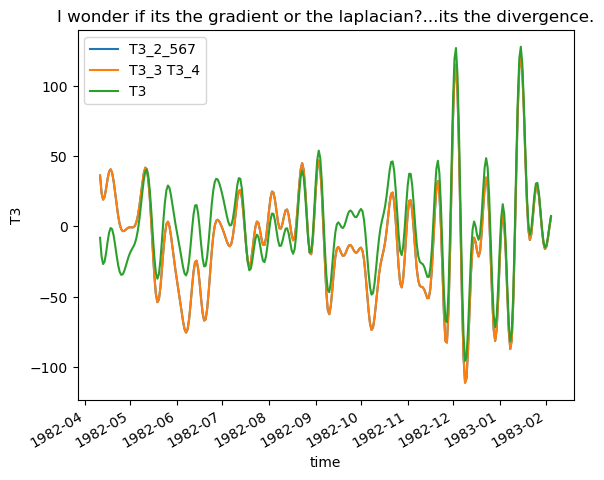

In [22]:
## Term 3_2_5
grad_vort_lf_x , grad_vort_lf_y = w.gradient(DS_cera0['vort_lf'])
grad_vort_clm_x , grad_vort_clm_y = w.gradient(DS_cera0['vrt_climo'])

term3_2_5_fst = (- DS_cera0['U_climo'] * grad_vort_lf_x - DS_cera0['V_climo'] * grad_vort_lf_y\
                - DS_cera0['u_10d_90d_band'] * grad_vort_clm_x - DS_cera0['v_10d_90d_band'] * grad_vort_clm_y).to_dataset(name='term3_2_5_fst')

term3_2_5_fst_lp = low_pass_DA(term3_2_5_fst['term3_2_5_fst'],ind_10d).to_dataset(name='term3_2_5_fst')
ilap_term3_2_5_fst = Inv_lap(DS_cera0,term3_2_5_fst_lp['term3_2_5_fst'])

ilap_T3_2_5 = (ilap_term3_2_5_fst['term3_2_5_fst_invlap']).to_dataset(name='T3_2_5')
print('..term3_2_5 done..')
## Term 3_2_5

## Term 3_2_6
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
term3_2_6_fst = (- (pvrt + DS_cera0['vrt_climo']) * divy(DS_cera0['u_10d_90d_band'],DS_cera0['v_10d_90d_band'])).to_dataset(name='term3_2_6_fst')
term3_2_6_snd = (- DS_cera0['vort_lf'] * divy((DS_cera0['U_climo']), (DS_cera0['V_climo']))).to_dataset(name='term3_2_6_snd')

term3_2_6_fst_lp = low_pass_DA(term3_2_6_fst['term3_2_6_fst'],ind_10d).to_dataset(name='term3_2_6_fst')
ilap_term3_2_6_fst = Inv_lap(DS_cera0,term3_2_6_fst_lp['term3_2_6_fst'])
term3_2_6_snd_lp = low_pass_DA(term3_2_6_snd['term3_2_6_snd'],ind_10d).to_dataset(name='term3_2_6_snd')
ilap_term3_2_6_snd = Inv_lap(DS_cera0,term3_2_6_snd_lp['term3_2_6_snd'])

ilap_term3_2_6_fst = Inv_lap(DS_cera0,term3_2_6_fst_lp['term3_2_6_fst'])
ilap_term3_2_6_snd = Inv_lap(DS_cera0,term3_2_6_snd_lp['term3_2_6_snd'])

ilap_T3_2_6 = (ilap_term3_2_6_fst['term3_2_6_fst_invlap']+ilap_term3_2_6_snd['term3_2_6_snd_invlap']).to_dataset(name='T3_2_6')
print('..term3_2_6 done..')
## Term 3_2_6

## Term 3_2_7
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
grad_pvrt_x , grad_pvrt_y = w.gradient(pvrt)
term3_2_7 = (-(DS_cera0['vwnd_lf_r']+ DS_cera0['vwnd_lf_d']) * grad_pvrt_y).to_dataset(name='term3_2_7')
##low pass:
tsindy = np.array(term3_2_7['term3_2_7'].sel(lat=30,lon=200,method='nearest'))
Z = np.fft.fft(tsindy)
Yfft = Z/np.size(tsindy)
freq = np.fft.rfftfreq(len(tsindy))
fs = 1 #day
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index :',ind_10d)
term3_2_7_lp = low_pass_DA(term3_2_7['term3_2_7'],ind_10d).to_dataset(name='term3_2_7')
ilap_T3_2_7 = Inv_lap(DS_cera0,term3_2_7_lp['term3_2_7'])
ilap_T3_2_7 = (ilap_T3_2_7['term3_2_7_invlap']).to_dataset(name='T3_2_7')

print('..term3_2_7 done..')
## Term 3_2_7

DS_cera0 = xr.merge([DS_cera0,ilap_T3_2_5,ilap_T3_2_6,ilap_T3_2_7])
DS_cera0.to_netcdf(tot_out,format="NETCDF4_CLASSIC")

(DS_cera0['T3_2_5']+DS_cera0['T3_2_6']+DS_cera0['T3_2_7']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_2_567')
(DS_cera0['T3_2_3']+DS_cera0['T3_2_4']).sel(lat=30,lon=200).isel(time=slice(100,400)).plot(label='T3_3 T3_4')
((DS_cera0['T3']).sel(lat=30,lon=200).isel(time=slice(100,400))).plot(label='T3')
plt.title('I wonder if its the gradient or the laplacian?...its the divergence.')
plt.legend()
plt.show()

In [23]:
DS_cera0.to_netcdf(tot_out,format="NETCDF4_CLASSIC")

## Beta test

## Do it and test against Gwendal 2015

In [24]:
DS_cera0 = xr.open_dataset(tot_out)
# DS_PQ = xr.open_dataset('/glade/scratch/wchapman/DA_ML_data/Random_Data/ERAi.h1_300mb_High_Low_Peiqiang_out_long_climo_BETATEST.nc')
# DS_cera0

# NOW COMPUTE THE FELDSTEIN COMPONENTS
- ***PAPER***: Fundamental mechanisms of the growth and decay of the PNA teleconnection pattern ( https://doi.org/10.1256/0035900021643683 , equation 2)

## Term 1

In [25]:
%%time 

w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()
grad_pvrt_x , grad_pvrt_y = w.gradient(pvrt)
term1 = (-(DS_cera0['vwnd_lf_r']+ DS_cera0['vwnd_lf_d']) * grad_pvrt_y).to_dataset(name='term1')
#term1 = (-(DS_cera0['vwnd_lf_r']) * grad_pvrt_y).to_dataset(name='term1') #rotational only

##low pass:
tsindy = np.array(term1['term1'].sel(lat=30,lon=200,method='nearest'))
Z = np.fft.fft(tsindy)
Yfft = Z/np.size(tsindy)
freq = np.fft.rfftfreq(len(tsindy))
fs = 1 #day
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index :',ind_10d)
term1_lp = low_pass_DA(term1['term1'],ind_10d).to_dataset(name='term1')

ilap_T1 = Inv_lap(DS_cera0,term1_lp['term1'])

#test
# (ilap_T1['term1_invlap'].sel(lat=40,lon=120).isel(time=slice(-50,-1))*86400).plot()
# DS_PQ['varout'].sel(term=1).sel(lat=40,lon=120).isel(time=slice(-50,-1)).plot()
# plt.show()

cutoff index : 1058
CPU times: user 31.8 s, sys: 3.29 s, total: 35.1 s
Wall time: 35.4 s


## Term2

In [26]:
%%time 

grad_vort_lf_x , grad_vort_lf_y = w.gradient(DS_cera0['vort_lf'])
grad_vort_clm_zm_x , grad_vort_clm_zm_y = w.gradient(DS_cera0['vort_clm_zm'])

term2_fst = (- DS_cera0['uwnd_clm_zm_r'] * grad_vort_lf_x - DS_cera0['vwnd_clm_zm_r'] * grad_vort_lf_y \
            - DS_cera0['uwnd_lf_r'] * grad_vort_clm_zm_x - DS_cera0['vwnd_lf_r'] * grad_vort_clm_zm_y).to_dataset(name='term2_fst')
  
term2_snd = (- DS_cera0['uwnd_clm_zm_d'] * grad_vort_lf_x - DS_cera0['vwnd_clm_zm_d'] * grad_vort_lf_y\
            - DS_cera0['uwnd_lf_d'] * grad_vort_clm_zm_x - DS_cera0['vwnd_lf_d'] * grad_vort_clm_zm_y).to_dataset(name='term2_snd')


term2_fst_lp = low_pass_DA(term2_fst['term2_fst'],ind_10d).to_dataset(name='term2_fst')
term2_snd_lp = low_pass_DA(term2_snd['term2_snd'],ind_10d).to_dataset(name='term2_snd')
ilap_term2_fst = Inv_lap(DS_cera0,term2_fst_lp['term2_fst'])
ilap_term2_snd = Inv_lap(DS_cera0,term2_snd_lp['term2_snd'])

ilap_T2 = (ilap_term2_fst['term2_fst_invlap'] + ilap_term2_snd['term2_snd_invlap']).to_dataset(name='term2_invlap')
# ilap_T2 = (ilap_term2_fst['term2_fst_invlap']).to_dataset(name='term2_invlap') #rotational only

# #test
# (ilap_T2['term2_invlap'].sel(lat=40,lon=100).isel(time=slice(-50,-1))*86400).plot()
# DS_PQ['varout'].sel(term=2).sel(lat=40,lon=100).isel(time=slice(-50,-1)).plot()
# plt.show()

CPU times: user 1min 2s, sys: 5.73 s, total: 1min 7s
Wall time: 1min 8s


## Term 3

In [27]:
%%time 

grad_vort_clm_sw_x , grad_vort_clm_sw_y = w.gradient(DS_cera0['vort_clm_sw'])

term3_fst = (- DS_cera0['uwnd_clm_sw_r'] * grad_vort_lf_x - DS_cera0['vwnd_clm_sw_r'] * grad_vort_lf_y\
                - DS_cera0['uwnd_lf_r'] * grad_vort_clm_sw_x - DS_cera0['vwnd_lf_r'] * grad_vort_clm_sw_y).to_dataset(name='term3_fst')

term3_snd = (- DS_cera0['uwnd_clm_sw_d'] * grad_vort_lf_x - DS_cera0['vwnd_clm_sw_d'] * grad_vort_lf_y\
                - DS_cera0['uwnd_lf_d'] * grad_vort_clm_sw_x - DS_cera0['vwnd_lf_d'] * grad_vort_clm_sw_y).to_dataset(name='term3_snd')

term3_fst_lp = low_pass_DA(term3_fst['term3_fst'],ind_10d).to_dataset(name='term3_fst')
term3_snd_lp = low_pass_DA(term3_snd['term3_snd'],ind_10d).to_dataset(name='term3_snd')
ilap_term3_fst = Inv_lap(DS_cera0,term3_fst_lp['term3_fst'])
ilap_term3_snd = Inv_lap(DS_cera0,term3_snd_lp['term3_snd'])


ilap_term3_fst = Inv_lap(DS_cera0,term3_fst_lp['term3_fst'])
ilap_term3_snd = Inv_lap(DS_cera0,term3_snd_lp['term3_snd'])

ilap_T3 = (ilap_term3_fst['term3_fst_invlap'] + ilap_term3_snd['term3_snd_invlap']).to_dataset(name='term3_invlap')
# ilap_T3 = (ilap_term3_fst['term3_fst_invlap']).to_dataset(name='term3_invlap') #rotational only

# #test
# (ilap_T3['term3_invlap'].sel(lat=40,lon=100).isel(time=slice(-50,-1))*86400).plot()
# DS_PQ['varout'].sel(term=3).sel(lat=40,lon=100).isel(time=slice(-50,-1)).plot()
# plt.show()

CPU times: user 1min 11s, sys: 4.73 s, total: 1min 16s
Wall time: 1min 17s


## Term4 

In [28]:
%%time
w = VectorWind(DS_cera0['U'],DS_cera0['V'])
pvrt = w.planetaryvorticity()

term4_fst = (- (pvrt + DS_cera0['vort_clm_zm'] + DS_cera0['vort_clm_sw']) * divy(DS_cera0['uwnd_lf_d'],DS_cera0['vwnd_lf_d'])).to_dataset(name='term4_fst')
term4_snd = (- DS_cera0['vort_lf'] * divy((DS_cera0['uwnd_clm_zm_d'] +  DS_cera0['uwnd_clm_sw_d']), (DS_cera0['vwnd_clm_zm_d'] +  DS_cera0['vwnd_clm_sw_d']))).to_dataset(name='term4_snd')


term4_fst_lp = low_pass_DA(term4_fst['term4_fst'],ind_10d).to_dataset(name='term4_fst')
term4_snd_lp = low_pass_DA(term4_snd['term4_snd'],ind_10d).to_dataset(name='term4_snd')
ilap_term4_fst = Inv_lap(DS_cera0,term4_fst_lp['term4_fst'])
ilap_term4_snd = Inv_lap(DS_cera0,term4_snd_lp['term4_snd'])


ilap_term4_fst = Inv_lap(DS_cera0,term4_fst_lp['term4_fst'])
ilap_term4_snd = Inv_lap(DS_cera0,term4_snd_lp['term4_snd'])
ilap_T4 = (ilap_term4_fst['term4_fst_invlap'] + ilap_term4_snd['term4_snd_invlap']).to_dataset(name='term4_invlap')
# ilap_T4 = (ilap_term4_fst['term4_fst_invlap']).to_dataset(name='term4_invlap') #rotational only 

# #test
# (ilap_T4['term4_invlap'].sel(lat=40,lon=100).isel(time=slice(-50,-1))*86400).plot(label='WEC')
# DS_PQ['varout'].sel(term=4).sel(lat=40,lon=100).isel(time=slice(-50,-1)).plot(label='PQ')
# plt.legend()
# plt.show()

CPU times: user 1min 30s, sys: 6.8 s, total: 1min 37s
Wall time: 1min 38s


## Term 5

In [29]:
%%time

term5_fst  = (- DS_cera0['uwnd_lf_r'] * grad_vort_lf_x - DS_cera0['vwnd_lf_r'] * grad_vort_lf_y).to_dataset(name='term5_fst')
term5_snd  = (- divy((DS_cera0['uwnd_lf_d'] * DS_cera0['vort_lf']), (DS_cera0['vwnd_lf_d'] * DS_cera0['vort_lf']))).to_dataset(name='term5_snd')

#####low pass filter
fs = 1 #obs per day
Udo_kp = np.array(DS_cera0['U'])
ts_Udo = Udo_kp[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index 20day:',ind_10d)
#######

lat=term5_fst['lat']
lon=term5_fst['lon']

t5_fst_filt = np.zeros_like(term5_fst['term5_fst'])
t5_snd_filt = np.zeros_like(term5_snd['term5_snd'])

ts_5_fst = np.array(term5_fst['term5_fst'])
ts_5_snd = np.array(term5_snd['term5_snd'])
print('Im sure you can do a 2d fft, but Im scared')
for lala in range(lat.shape[0]):
    if lala%10==0:
        print(lala,'of: ',lat.shape[0])
    for lolo in range(lon.shape[0]):
        ts_5_fstdo = ts_5_fst[:,lala,lolo]
        ts_5_snddo = ts_5_snd[:,lala,lolo]
        t5_fst_filt[:,lala,lolo] = filt_low(ts_5_fstdo,ind_10d)
        t5_snd_filt[:,lala,lolo] = filt_low(ts_5_snddo,ind_10d)
        
t5_fst_L = xr.Dataset(
        {
            "term5_fst": (["time","lat", "lon"],t5_fst_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

t5_snd_L = xr.Dataset(
        {
            "term5_snd": (["time","lat", "lon"],t5_snd_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)


ilap_term5_fst = Inv_lap(DS_cera0,t5_fst_L['term5_fst'])
ilap_term5_snd = Inv_lap(DS_cera0,t5_snd_L['term5_snd'])
ilap_T5 = (ilap_term5_fst['term5_fst_invlap'] + ilap_term5_snd['term5_snd_invlap']).to_dataset(name='term5_invlap')

# #test
# (ilap_T5['term5_invlap'].sel(lat=50,lon=210).isel(time=slice(-50,-1))*86400).plot(label='WEC')
# DS_PQ['varout'].sel(term=5).sel(lat=50,lon=210).isel(time=slice(-50,-1)).plot(label='PQ')
# plt.legend()
# plt.show()

cutoff index 20day: 1058
Im sure you can do a 2d fft, but Im scared
0 of:  73
10 of:  73
20 of:  73
30 of:  73
40 of:  73
50 of:  73
60 of:  73
70 of:  73
CPU times: user 52.7 s, sys: 3.37 s, total: 56.1 s
Wall time: 56.2 s


## Term 6

In [30]:
%%time

grad_vort_hf_x , grad_vort_hf_y = w.gradient(DS_cera0['vort_hf'])

term6_fst = (- DS_cera0['uwnd_hf_r'] * grad_vort_hf_x - DS_cera0['vwnd_hf_r'] * grad_vort_hf_y).to_dataset(name='term6_fst')
term6_snd = (- divy((DS_cera0['uwnd_hf_d'] * DS_cera0['vort_hf']), (DS_cera0['vwnd_hf_d'] * DS_cera0['vort_hf']))).to_dataset(name='term6_snd')

#####low pass filter
fs = 1 #obs per day
Udo_kp = np.array(DS_cera0['U'])
ts_Udo = Udo_kp[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index 20day:',ind_10d)
#######

lat=term6_fst['lat']
lon=term6_fst['lon']

t6_fst_filt = np.zeros_like(term6_fst['term6_fst'])
t6_snd_filt = np.zeros_like(term6_snd['term6_snd'])

ts_6_fst = np.array(term6_fst['term6_fst'])
ts_6_snd = np.array(term6_snd['term6_snd'])
print('Im sure you can do a 2d fft, but Im scared')
for lala in range(lat.shape[0]):
    if lala%10==0:
        print(lala,'of: ',lat.shape[0])
    for lolo in range(lon.shape[0]):
        ts_6_fstdo = ts_6_fst[:,lala,lolo]
        ts_6_snddo = ts_6_snd[:,lala,lolo]
        t6_fst_filt[:,lala,lolo] = filt_low(ts_6_fstdo,ind_10d)
        t6_snd_filt[:,lala,lolo] = filt_low(ts_6_snddo,ind_10d)
        
t6_fst_L = xr.Dataset(
        {
            "term6_fst": (["time","lat", "lon"],t6_fst_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

t6_snd_L = xr.Dataset(
        {
            "term6_snd": (["time","lat", "lon"],t6_snd_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

#####low pass filter

ilap_term6_fst = Inv_lap(DS_cera0,t6_fst_L['term6_fst'])
ilap_term6_snd = Inv_lap(DS_cera0,t6_snd_L['term6_snd'])
ilap_T6 = (ilap_term6_fst['term6_fst_invlap'] + ilap_term6_snd['term6_snd_invlap']).to_dataset(name='term6_invlap')

# #test
# (ilap_T6['term6_invlap'].sel(lat=50,lon=210).isel(time=slice(-50,-1))*86400).plot(label='WEC')
# DS_PQ['varout'].sel(term=6).sel(lat=50,lon=210).isel(time=slice(-50,-1)).plot(label='PQ')
# plt.legend()
# plt.show()

cutoff index 20day: 1058
Im sure you can do a 2d fft, but Im scared
0 of:  73
10 of:  73
20 of:  73
30 of:  73
40 of:  73
50 of:  73
60 of:  73
70 of:  73
CPU times: user 1min 2s, sys: 4.81 s, total: 1min 7s
Wall time: 1min 7s


## Term 7

In [31]:
%%time
term7_fst = (-  DS_cera0['uwnd_lf_r'] * grad_vort_hf_x -  DS_cera0['vwnd_lf_r'] * grad_vort_hf_y).to_dataset(name='term7_fst')
term7_snd = - (divy((DS_cera0['uwnd_lf_d'] * DS_cera0['vort_hf']), (DS_cera0['vwnd_lf_d'] * DS_cera0['vort_hf']))).to_dataset(name='term7_snd')
term7_thd = ((- DS_cera0['uwnd_hf_r'] * grad_vort_lf_x) - (DS_cera0['vwnd_hf_r'] * grad_vort_lf_y)).to_dataset(name='term7_thd')
term7_for = (- divy(DS_cera0['uwnd_hf_d'] * DS_cera0['vort_lf'], DS_cera0['vwnd_hf_d'] * DS_cera0['vort_lf'])).to_dataset(name='term7_for')

#####low pass filter
fs = 1 #obs per day
Udo_kp = np.array(DS_cera0['U'])
ts_Udo = Udo_kp[:,30,30]
Z = np.fft.fft(ts_Udo)
Yfft = Z/np.size(ts_Udo)
freq = np.fft.rfftfreq(len(ts_Udo))
perd = fs/freq[1:]
val_10d, ind_10d = find_nearest(perd,value=10)
print('cutoff index 20day:',ind_10d)
#######

lat=term7_fst['lat']
lon=term7_fst['lon']

t7_fst_filt = np.zeros_like(term7_fst['term7_fst'])
t7_snd_filt = np.zeros_like(term7_snd['term7_snd'])
t7_thd_filt = np.zeros_like(term7_thd['term7_thd'])
t7_for_filt = np.zeros_like(term7_for['term7_for'])

ts_7_fst = np.array(term7_fst['term7_fst'])
ts_7_snd = np.array(term7_snd['term7_snd'])
ts_7_thd = np.array(term7_thd['term7_thd'])
ts_7_for = np.array(term7_for['term7_for'])
print('Im sure you can do a 2d fft, but Im scared')

for lala in range(lat.shape[0]):
    if lala%10==0:
        print(lala,'of: ',lat.shape[0])
    for lolo in range(lon.shape[0]):
        ts_7_fstdo = ts_7_fst[:,lala,lolo]
        ts_7_snddo = ts_7_snd[:,lala,lolo]
        ts_7_thddo = ts_7_thd[:,lala,lolo]
        ts_7_fordo = ts_7_for[:,lala,lolo]
        t7_fst_filt[:,lala,lolo] = filt_low(ts_7_fstdo,ind_10d)
        t7_snd_filt[:,lala,lolo] = filt_low(ts_7_snddo,ind_10d)
        t7_thd_filt[:,lala,lolo] = filt_low(ts_7_thddo,ind_10d)
        t7_for_filt[:,lala,lolo] = filt_low(ts_7_fordo,ind_10d)
        
t7_fst_L = xr.Dataset(
        {
            "term7_fst": (["time","lat", "lon"],t7_fst_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

t7_snd_L = xr.Dataset(
        {
            "term7_snd": (["time","lat", "lon"],t7_snd_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

t7_thd_L = xr.Dataset(
        {
            "term7_thd": (["time","lat", "lon"],t7_thd_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

t7_for_L = xr.Dataset(
        {
            "term7_for": (["time","lat", "lon"],t7_for_filt),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)


#####low pass filter

#####Inverse Laplacian:
ilap_term7_fst = Inv_lap(DS_cera0,t7_fst_L['term7_fst'])
ilap_term7_snd = Inv_lap(DS_cera0,t7_snd_L['term7_snd'])
ilap_term7_thd = Inv_lap(DS_cera0,t7_thd_L['term7_thd'])
ilap_term7_for = Inv_lap(DS_cera0,t7_for_L['term7_for'])
ilap_T7 = (ilap_term7_fst['term7_fst_invlap'] + ilap_term7_snd['term7_snd_invlap']+ilap_term7_thd['term7_thd_invlap']+ilap_term7_for['term7_for_invlap'] ).to_dataset(name='term7_invlap')

# #test
# (ilap_T7['term7_invlap'].sel(lat=38,lon=210,method='nearest').isel(time=slice(-50,-1))*86400).plot(label='WEC')
# DS_PQ['varout'].sel(term=7).sel(lat=38,lon=210,method='nearest').isel(time=slice(-50,-1)).plot(label='PQ')
# plt.legend()
# plt.show()

cutoff index 20day: 1058
Im sure you can do a 2d fft, but Im scared
0 of:  73
10 of:  73
20 of:  73
30 of:  73
40 of:  73
50 of:  73
60 of:  73
70 of:  73
CPU times: user 1min 50s, sys: 6.91 s, total: 1min 57s
Wall time: 1min 58s


## Combine and Remove the Climo of the Nonlinear Terms

In [32]:
%%time

term5_np=np.zeros_like(ilap_T5['term5_invlap'])
term6_np=np.zeros_like(ilap_T6['term6_invlap'])
term7_np=np.zeros_like(ilap_T7['term7_invlap'])

term5_xr=xr.zeros_like(ilap_T5['term5_invlap'])
term6_xr=xr.zeros_like(ilap_T6['term6_invlap'])
term7_xr=xr.zeros_like(ilap_T7['term7_invlap'])

lat = DS_cera0['lat']
lon = DS_cera0['lon']

t5do  = np.array(ilap_T5['term5_invlap'])
t6do  = np.array(ilap_T6['term6_invlap'])
t7do  = np.array(ilap_T7['term7_invlap'])

print('regressing out seasonal cycle')
for lala in range(lat.shape[0]):
    for lolo in range(lon.shape[0]):
        dt5 = copy.deepcopy(t5do[:,lala,lolo])
        dt6 = copy.deepcopy(t6do[:,lala,lolo])
        dt7 = copy.deepcopy(t7do[:,lala,lolo])
        
        term5_np[:,lala,lolo]=regress_out_seasonal(dt5)
        term6_np[:,lala,lolo]=regress_out_seasonal(dt6)
        term7_np[:,lala,lolo]=regress_out_seasonal(dt7)
print('...merging...')        
term5_xr[:,:,:]=term5_np
term6_xr[:,:,:]=term6_np
term7_xr[:,:,:]=term7_np

term5_xr = term5_xr.to_dataset(name='term5')
term6_xr = term6_xr.to_dataset(name='term6')
term7_xr = term7_xr.to_dataset(name='term7')

feldstein_out = xr.merge([ilap_T1.rename({'term1_invlap':'term1'}),
        ilap_T2.rename({'term2_invlap':'term2'}),
        ilap_T3.rename({'term3_invlap':'term3'}),
        ilap_T4.rename({'term4_invlap':'term4'}),
        term5_xr,term6_xr,term7_xr])


linearterm = ilap_T1['term1_invlap']+ilap_T2['term2_invlap']+ilap_T3['term3_invlap']+ilap_T4['term4_invlap']
linearterm = linearterm.to_dataset(name='linear')

nonlinearterm = feldstein_out['term5']+feldstein_out['term6'] +feldstein_out['term7']
nonlinearterm = nonlinearterm.to_dataset(name='nonlinear')
total_forcing = feldstein_out['term1']+feldstein_out['term2']+feldstein_out['term3']+feldstein_out['term4']\
                +feldstein_out['term5']+feldstein_out['term6'] +feldstein_out['term7']
total_forcing = total_forcing.to_dataset(name='total_forcing')

SF = Inv_lap(DS_cera0,DS_cera0['vort_lf'])
SF = SF.rename({'vort_lf_invlap':'StreamFunction_L'})

SF_tend = np.gradient(SF['StreamFunction_L'],axis=0)
SFt = xr.Dataset(
        {
            "StreamFunction_tend": (["time","lat", "lon"],SF_tend),
        },
        coords={
            "time":DS_cera0['time'],
            "lat":np.array(lat),
            "lon":np.array(lon),
        },)

feldstein_out = xr.merge([feldstein_out,linearterm,nonlinearterm,total_forcing,SF,SFt])
feldstein_out = feldstein_out*86400
print('...done...')
print('...saving...')
feldstein_out.to_netcdf(feldstein_out_comp)

regressing out seasonal cycle
...merging...
...done...
...saving...
CPU times: user 36.3 s, sys: 6.58 s, total: 42.8 s
Wall time: 43.4 s
